# Online Shoppers Purchasing Intention 
* 一共有18個欄位，所需要預測的目標為最後一欄的revenue，也就是根據前面17個不同的屬性去預測出有消費還是沒有消費，不過這份資料集中為負樣本的比例相當高。

## 匯入所需要的套件

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD 
from torch.autograd import Variable
SEED = 10

## 讀入資料集
* 大致上參閱這份資料，一共有18個欄位
* 12330筆資料，其中沒有需要填補的缺失值。
* Administrative、Informational、ProductRelated和其duration是不同的網頁類型和他們所停留在上面的時間
* BounceRates、ExitRates、PageValues這三種比率
    * BR是進入網頁後沒有點擊任何東東就離開
    * ER是有瀏覽後在某頁離開
    * PV是完成交易後平均的網頁價值
* SpecialDay離特殊節日的接近度
* Month 月份
* OperatingSystems是使用哪一種作業系統，不過在這離好像被簡單的使用編號來取代（省的我們還要自己做處理）
* Browser使用哪一種瀏覽器
* Region消費者的地區
* TrafficType 資料中好像沒有說明
* VisitorType  是returning or new visitor
* Weekend是否為假日？
* **Revenue**最後是有購買還是沒有購買

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

#### 先做類別對應到數值轉換

In [4]:
Month_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
Visitor_map = {'Returning_Visitor':0,'New_Visitor':1,'Other':2}
Weekend_map = {False:0,True:1}
Revenue_map = {False:0,True:1}
df['Month'] = df['Month'].map(Month_map)
df['VisitorType'] = df['VisitorType'].map(Visitor_map)
df['Weekend'] = df['Weekend'].map(Weekend_map)
df['Revenue'] = df['Revenue'].map(Revenue_map)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,0,1,0


## 查看各個欄位與是否購買的關係

### 這份資料正負樣本的比例
* 算蠻不均衡的 沒買的就佔8成

有買的：0.15474452554744525
沒有買的：0.8452554744525548


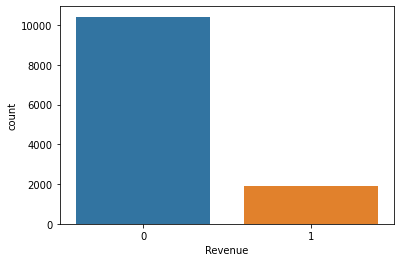

In [5]:
base = df['Revenue'].mean()
print('有買的：{}'.format(base))
print('沒有買的：{}'.format(1-base))
sns.countplot(x='Revenue',data=df)
plt.show()

### 月份與revenue
* 十一十二月購買人比較多則有可能是因為1127黑色星期五造成的原因

,Revenue
Month,
2,0.016304
3,0.100682
5,0.108502
6,0.100694
7,0.152778
8,0.175520
9,0.191964
10,0.209472
11,0.253502


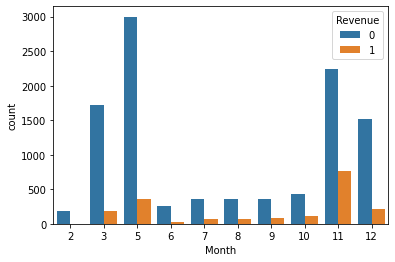

In [6]:
class_group = df[['Month','Revenue']].groupby('Month')
display(class_group.mean())
sns.countplot(x='Month',hue='Revenue',data=df)
plt.show()

### 瀏覽器與Revenue

,Revenue
Browser,
1,0.148253
2,0.153624
3,0.047619
4,0.176630
5,0.184154
6,0.114943
7,0.122449
8,0.155556
9,0.000000


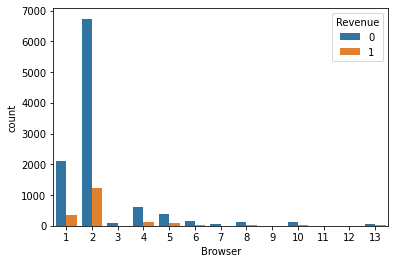

In [7]:
class_group = df[['Browser','Revenue']].groupby('Browser')
display(class_group.mean())
sns.countplot(x='Browser',hue='Revenue',data=df)
plt.show()

### OS與Revenue
* 感覺作業系統影響的比例好像不是很大，大部分或購買的都佔1-2成左右，若是購買數量比較多的大概也就是他的人口基數本來就比較多。

,Revenue
OperatingSystems,
1,0.146615
2,0.174973
3,0.104892
4,0.177824
5,0.166667
6,0.105263
7,0.142857
8,0.215190


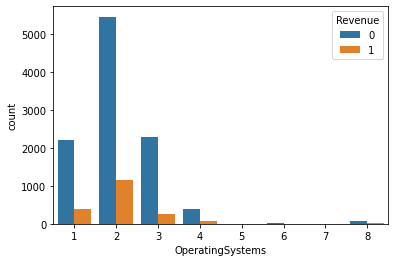

In [8]:
class_group = df[['OperatingSystems','Revenue']].groupby('OperatingSystems')
display(class_group.mean())
sns.countplot(x='OperatingSystems',hue='Revenue',data=df)
plt.show()

## Weekend與Revenue
* 假日的購買力較強 較非假日多出3%

,Revenue
Weekend,
0,0.148911
1,0.173989


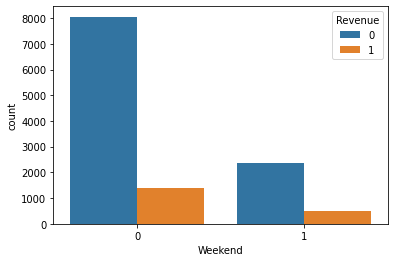

In [9]:
class_group = df[['Weekend','Revenue']].groupby('Weekend')
display(class_group.mean())
sns.countplot(x='Weekend',hue='Revenue',data=df)
plt.show()

## 是不是特殊節日與revenue
* 這邊有點特別，跟我原本預期的相反了

In [10]:
rate_special = df[(df['SpecialDay']>0) & (df['Revenue'] == True)].SpecialDay.count()/df[(df['SpecialDay']>0)].SpecialDay.count()
rate_nspe = df[(df['SpecialDay']==0) & (df['Revenue'] == True)].SpecialDay.count()/df[(df['SpecialDay']==0)].SpecialDay.count()
print('在特殊節日買的:{}'.format(rate_special))
print('不在特殊節日買的:{}'.format(rate_nspe))

在特殊節日買的:0.06155075939248601
不在特殊節日買的:0.16526762343171766


## 地區與revenue

,Revenue
Region,
1,0.161297
2,0.165493
3,0.145235
4,0.148054
5,0.163522
6,0.139130
7,0.156373
8,0.129032
9,0.168297


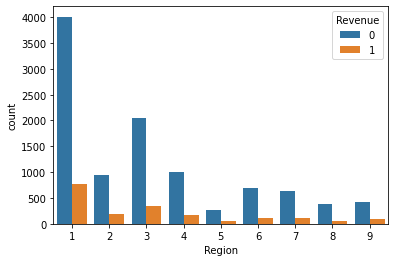

In [11]:
class_group = df[['Region','Revenue']].groupby('Region')
display(class_group.mean())
sns.countplot(x='Region',hue='Revenue',data=df)
plt.show()

## 三種rate與revenue
* BounceRates、ExitRates、PageValues

#### BounceRates在超過0.25購買的機率就剩很低了

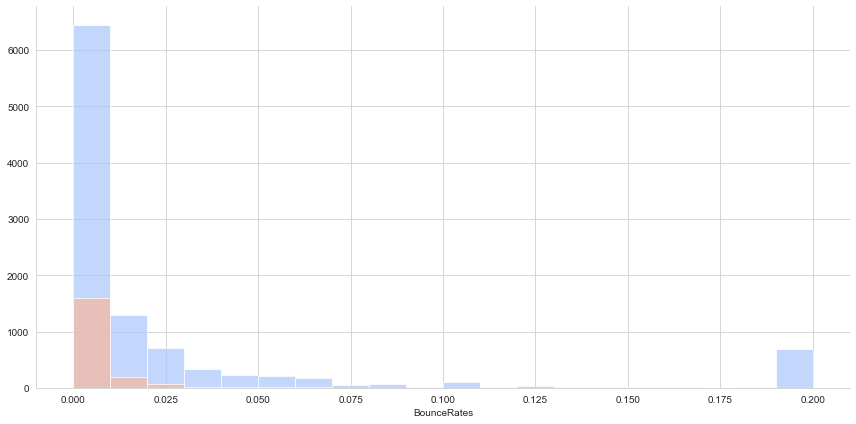

In [12]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="Revenue",palette='coolwarm',height=6,aspect=2)
g = g.map(plt.hist,'BounceRates',bins=20,alpha=0.7)

#### ExitRate在過0.75之後會買的就很少了

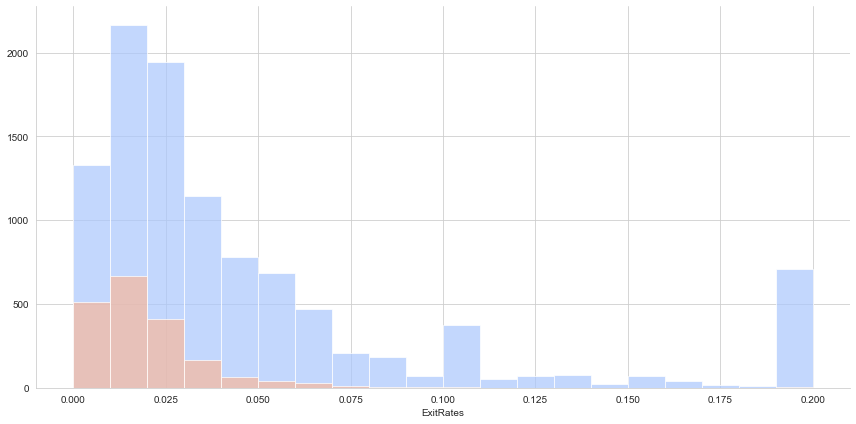

In [13]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="Revenue",palette='coolwarm',height=6,aspect=2)
g = g.map(plt.hist,'ExitRates',bins=20,alpha=0.7)

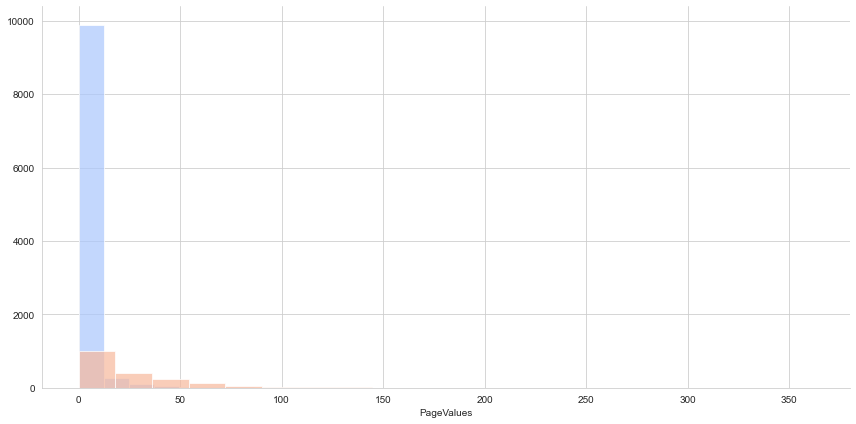

In [14]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="Revenue",palette='coolwarm',height=6,aspect=2)
g = g.map(plt.hist,'PageValues',bins=20,alpha=0.7)

## 製作相關係數的熱點圖
* 可以看得出來page value有蠻大的相關性

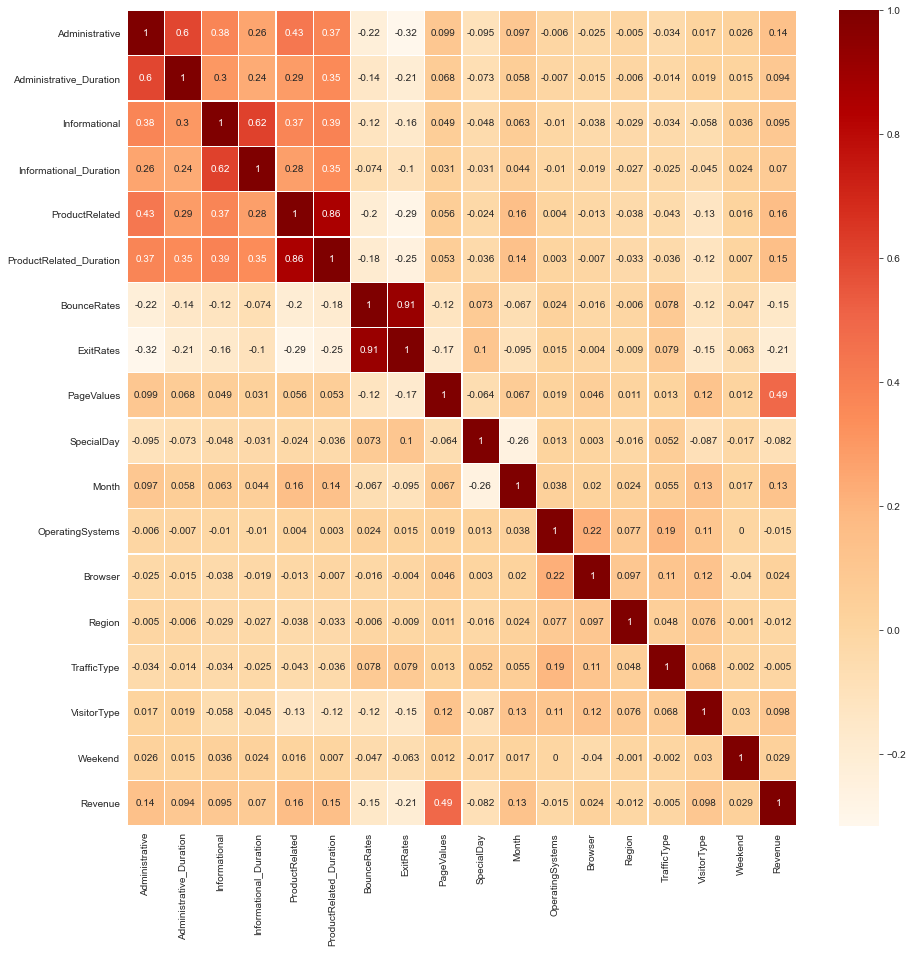

In [15]:
df_corr = df.corr().round(3)
plt.figure(figsize=(15,15))
sns.heatmap(data=df_corr,annot=True,linewidths=0.3,cmap='OrRd')

## 對資料進行前處理
* 嘗試將類別型資料，或者TrueFalse的欄位，進行OHE（one-hot encoding）、或者將其對應到0、1或是數值



### 轉OHE（跑一次而已）
* 類別有關的資料有幾個可以轉的OHE的，Month、OperatingSystems、Region、Browser、TrafficType、VisitorType
* 讓類別型資料不會受到以數值label時數字大小所造成的影響

In [16]:
#select_col = ['Month','OperatingSystems','Region','Browser','TrafficType','VisitorType']
select_col = ['Month','VisitorType']
df=pd.get_dummies(df,columns=select_col)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  OperatingSystems         12330 non-null  int64  
 11  Browser                  12330 non-null  int64  
 12  Region                   12330 non-null  int64  
 13  TrafficType              12330 non-null  int64  
 14  Weekend               

### 將數據標準化（跑一次就好了）
* 有數值的欄位：Administrative、Administrative_Duration、Informational 、Informational_Duration、ProductRelated、ProductRelated_Duration、BounceRates、ExitRates、PageValues、SpecialDay

In [17]:
#std_col = ['Administrative','Administrative_Duration','Informational','Informational_Duration',
#           'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates',
 #          'PageValues','SpecialDay']
std_col = ['Administrative','Administrative_Duration','Informational','Informational_Duration',
           'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates',
           'PageValues']
scaler = StandardScaler()
scaler.fit(df[std_col])
df[std_col] = scaler.transform(df[std_col])

## 切分資料集和測試集
* 不過基本上資料已經不平衡了，所以只要猜1應該準確率就會很高
* 選擇在熱點圖中與revenue較相關的幾個特徵
    * 也有試過全部都當成特徵丟進去，雖然出來的準確率很接近，不過選幾個特徵出來後準確率有高1%左右

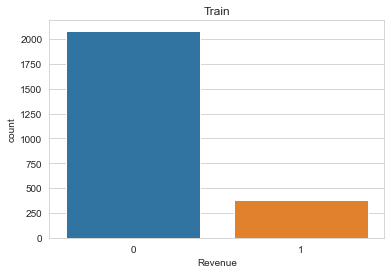

In [18]:
dfX = df.drop(columns=['Revenue','SpecialDay','OperatingSystems','Region','Browser','TrafficType','Weekend']).copy()
dfY = df['Revenue'].copy()
dfY.head()
trainX, testX, trainY, testY = train_test_split(dfX, dfY, test_size=0.2,stratify=dfY, random_state=SEED)
sns.countplot(testY)
plt.title('Train')
plt.show()


## 對資料進行預測

### 將資料集全部猜0的準確率
* 基本上希望之後用模型預測出來的結果要大於這個

In [19]:
allone = testY.sum()
acc_allone = 1-(allone/len(testY))
print('Accuracy:{}'.format(acc_allone))

Accuracy:0.8450932684509327


### 使用Logistic Regression
* 想比全部都猜0還要好了一些，大約3-4%

In [20]:
modelLR = LogisticRegression(random_state=SEED,max_iter=3000)
modelLR.fit(trainX,trainY)
result_LR = modelLR.predict(testX)
preLR_tra = modelLR.score(trainX,trainY)
preLR_tes = modelLR.score(testX,testY)
print('Train Accuracy:{}'.format(preLR_tra))
print('Test Accuracy:{}'.format(preLR_tes))
print('Confusion Matrix：')
print(confusion_matrix(testY, result_LR))

Train Accuracy:0.8835158150851582
Test Accuracy:0.889294403892944
Confusion Matrix：
[[2042   42]
 [ 231  151]]


### 使用SVM
* 使用SVM的結果其實也蠻優異的

In [21]:
modelSVM = SVC(random_state=SEED)
modelSVM.fit(trainX,trainY)
result_SVM = modelSVM.predict(testX)
preSVM_tra = modelSVM.score(trainX,trainY)
preSVM_tes = modelSVM.score(testX,testY)
print('Train Accuracy:{}'.format(preSVM_tra))
print('Test Accuracy:{}'.format(preSVM_tes))
print('Confusion Matrix：')
print(confusion_matrix(testY, result_SVM))

Train Accuracy:0.9037915652879156
Test Accuracy:0.902676399026764
Confusion Matrix：
[[2024   60]
 [ 180  202]]


### 嘗試使用Neural Network

#### 將數據修改成可以丟進model的形式

In [22]:
X = trainX[:].values
Y = trainY[:].values
X = X.reshape(-1,trainX.shape[1])
Y = Y.reshape(-1,1)
X = torch.from_numpy(X).type(torch.FloatTensor)
Y = torch.from_numpy(Y).type(torch.FloatTensor)
NtestX = testX[:].values
NtestX = NtestX.reshape(-1,testX.shape[1])
#NtestX = np.array(NtestX)
NtestX = torch.from_numpy(NtestX).type(torch.FloatTensor)

torch_dataset = TensorDataset(X,Y)

loader = DataLoader(
    dataset = torch_dataset,
    batch_size = 8,
    shuffle=True,
    num_workers=2
)
print('Done')


Done


#### 建立模型

In [23]:
IN = trainX.shape[1]
class MyModel(nn.Module):
        def __init__(self):
            super(MyModel,self).__init__()
            
            self.L1 = nn.Linear(
                in_features=IN,
                out_features=100
            )
            self.L2 = nn.Linear(
                in_features=100,
                out_features=1
            )
        
        def forward(self, batch_x):
            y = self.L1(batch_x)
            y = F.relu(y)
            y = self.L2(y)
            y = F.sigmoid(y)
            return y
        def predict(self,x):
            pred = self.forward(x)
            ans = []
            for t in pred:
                if t[0]>0.5:
                    ans.append(1)
                else:
                    ans.append(0)

            return torch.tensor(ans)

print('Done')

Done


#### 訓練模型
* 可以發現以batch size=8 跑30個epoch的時候，在前10個epoch對訓練集的準確率是有機會較高的，但是隨著越來越多次的訓練，由於在訓練樣本中負樣本就已經佔多數，導致對樣本的預判越來越傾向偏負，所以準確率越來越下降。

/Users/chu/anaconda3/envs/DA/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 3,Step:1232, Loss: 0.1541530340909958
Train Accuracy: 0.8788523925385239
Epoch: 6,Step:1232, Loss: 0.315529465675354
Train Accuracy: 0.8611111111111112
Epoch: 9,Step:1232, Loss: 0.3149121105670929
Train Accuracy: 0.8499594484995945
Epoch: 12,Step:1232, Loss: 0.40346795320510864
Train Accuracy: 0.8666869424168694
Epoch: 15,Step:1232, Loss: 0.37381085753440857
Train Accuracy: 0.8453974047039741
Epoch: 18,Step:1232, Loss: 0.02994585409760475
Train Accuracy: 0.8454987834549879
Epoch: 21,Step:1232, Loss: 0.5895161032676697
Train Accuracy: 0.8450932684509327
Epoch: 24,Step:1232, Loss: 0.28663545846939087
Train Accuracy: 0.6442619626926196
Epoch: 27,Step:1232, Loss: 0.03591332957148552
Train Accuracy: 0.8461070559610706
Epoch: 30,Step:1232, Loss: 12.938874244689941
Train Accuracy: 0.8457015409570154


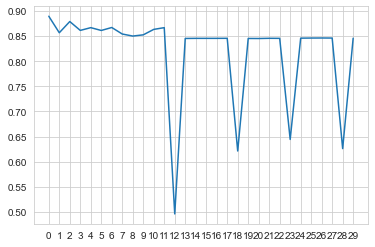

In [27]:
model = MyModel()
optimizer = SGD(model.parameters(),lr=0.001)
criterion = nn.BCELoss()

epochs = 30
losses = []
acc=[]
for i in range(epochs):
    for step,(batch_x,batch_y) in enumerate(loader):
        y_pred = model(batch_x)  
        loss = criterion(y_pred,batch_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    predict = model.predict(X)
    predict_train = predict.numpy()
    train_acc = accuracy_score(trainY,predict_train)
    acc.append(train_acc)
    if (i + 1) % 3== 0:
        print('Epoch: {},Step:{}, Loss: {}'.format(i + 1,step, loss))
        print('Train Accuracy: {}'.format(train_acc))

t= np.arange(0, epochs, 1)
plt.plot(t,acc)
plt.xticks(t)
plt.show()        

#### 保存訓練好的模型

In [30]:
#torch.save(model.state_dict(), 'normal_model_plus.ckpt')

#### 測試訓練好的模型
* 準確率只有接近0.85，沒有比原本的基準還要更好。

In [31]:
model_predict = MyModel()
model_predict.load_state_dict(torch.load('./normal_model_plus.ckpt'))
predict = model_predict.predict(NtestX)
predict = predict.numpy()
test_acc = accuracy_score(testY,predict)
print('Test Accuracy: {}'.format(test_acc))
print('Confusion Matrix：')
print(confusion_matrix(testY, predict))#混淆矩陣

Test Accuracy: 0.8467153284671532
Confusion Matrix：
[[2083    1]
 [ 377    5]]


## **對準確率的改進**

### Neural Network的改善

#### 已知問題
* 不進行優化的時候準確率大概只比全猜0還要好一點。
* 當選擇的epoch太高的時候，一直訓練的結果有可能因為負樣本比例不均，使模型一直往負那邊靠近。
    * 同時也要跟著batch size 改變epoch
* 也有可能模型網路建構的太簡單， 沒辦法對資料有更好的適配。
    * 把hidden layer 設的複雜一點
* 一開始batch size設的不高，導致預測無法收斂，一直往局部最佳解靠近，無法跳脫到全域最佳解。
    * 將batch size調得高一點


#### 重新建立dataset
* 將batch size調高
* 將epoch降低

In [32]:
loader = DataLoader(
    dataset = torch_dataset,
    batch_size = 256,
    shuffle=True,
    num_workers=10
)

print('Done')

Done


#### 重新建構模型

In [33]:
IN = trainX.shape[1]
class NewModel(nn.Module):
        def __init__(self):
            super(NewModel,self).__init__()
            
            self.L1 = nn.Linear(
                in_features=IN,
                out_features=50
            )
            self.L2 = nn.Linear(
                in_features = 50,
                out_features = 70
            )
            self.L3 = nn.Linear(
                in_features = 70,
                out_features = 20
            )
            self.L4= nn.Linear(
                in_features=20,
                out_features=1
            )
        
        def forward(self, batch_x):
            y = self.L1(batch_x)
            y = F.relu(y)
            y = self.L2(y)
            y = F.relu(y)
            y = self.L3(y)
            y = F.relu(y)
            y = self.L4(y)
            y = F.sigmoid(y)
            return y
        def predict(self,x):
            pred = self.forward(x)
            ans = []
            for t in pred:
                if t[0]>0.5:
                    ans.append(1)
                else:
                    ans.append(0)

            return torch.tensor(ans)

print('Done')

Done


#### 訓練模型

Epoch: 5,Step:38, Loss: 0.5084869861602783
Train Accuracy: 0.8452960259529603
Epoch: 10,Step:38, Loss: 0.49476444721221924
Train Accuracy: 0.8452960259529603
Epoch: 15,Step:38, Loss: 0.31501808762550354
Train Accuracy: 0.845904298459043
Epoch: 20,Step:38, Loss: 0.33968856930732727
Train Accuracy: 0.8932481751824818
Epoch: 25,Step:38, Loss: 0.26473718881607056
Train Accuracy: 0.8452960259529603
Epoch: 30,Step:38, Loss: 0.3543134331703186
Train Accuracy: 0.8761151662611517
Epoch: 35,Step:38, Loss: 0.266979455947876
Train Accuracy: 0.8899026763990268
Epoch: 40,Step:38, Loss: 0.19095288217067719
Train Accuracy: 0.879764801297648
Epoch: 45,Step:38, Loss: 0.19777150452136993
Train Accuracy: 0.8960867802108679
Epoch: 50,Step:38, Loss: 0.21275365352630615
Train Accuracy: 0.8930454176804542
Epoch: 55,Step:38, Loss: 0.20875264704227448
Train Accuracy: 0.8950729927007299
Epoch: 60,Step:38, Loss: 0.27904170751571655
Train Accuracy: 0.8948702351987023
Epoch: 65,Step:38, Loss: 0.2403697669506073
Tra

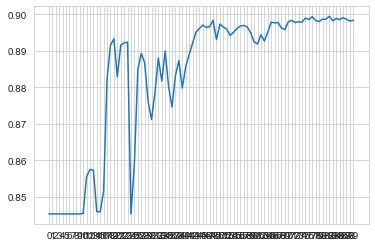

In [34]:
model = NewModel()
optimizer = SGD(model.parameters(),lr=0.001)
W= torch.tensor(0.9)#給予權重
criterion = nn.BCELoss(weight=W)

losses = []

epochs = 90
acc=[]
for i in range(epochs):
    for step,(batch_x,batch_y) in enumerate(loader):
        y_pred = model(batch_x)  
        loss = criterion(y_pred,batch_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
    predict = model.predict(X)
    predict_train = predict.numpy()
    train_acc = accuracy_score(trainY,predict_train)
    acc.append(train_acc)
    if (i + 1) % 5== 0:
        print('Epoch: {},Step:{}, Loss: {}'.format(i + 1,step, loss))
        print('Train Accuracy: {}'.format(train_acc))
        
t= np.arange(0, epochs, 1)
plt.plot(t,acc)
plt.xticks(t)
plt.show()

#### 保存模型

In [35]:
#torch.save(model.state_dict(), 'new_model_E90_W9.ckpt')

#### 測試訓練過後的模型

In [36]:
Nmodel_predict = NewModel()
Nmodel_predict.load_state_dict(torch.load('./new_model_E90_W9.ckpt'))
Npredict = Nmodel_predict.predict(NtestX)
Npredict = Npredict.numpy()
Ntest_acc = accuracy_score(testY,Npredict)
print('Test Accuracy: {}'.format(Ntest_acc))
print('Confusion Matrix：')
print(confusion_matrix(testY, Npredict))#混淆矩陣

Test Accuracy: 0.9038929440389294
Confusion Matrix：
[[1985   99]
 [ 138  244]]


/Users/chu/anaconda3/envs/DA/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


#### 結果
* 對於上述所講的問題進行一些調教之後，可以發現結果的確是有變好的。
* 由於將模型中架構變複雜，而且batchsize有拉高，原本只跑50個不到的epoch，但從圖片上可以發現訓練時的準確度即使在50上下還是有繼續往上的趨勢，最後將epoch直接調到100，發現90個epoch左右趨勢就開始減緩，大概落在九成，甚至有往下的趨勢，因此選擇停在90。
* 將對預測成正樣本的權重抓在0.9
* 模型的架構為特徵數->50->70->20->1
* 最後對訓練集的準確率在9成，未調教前在8.4成左右
* 對測試集的準確率也在9成，未調教之前在8.4-8.5成

### 選擇直接嘗試其他模型
* 選擇使用random forest來分類
* 結果意外的非常好，只使用預設值就有高達九成的準確率

In [37]:
modelRF = RandomForestClassifier(random_state=SEED)
modelRF.fit(trainX,trainY)
preRF_tra = modelRF.score(trainX,trainY)
preRF_tes = modelRF.score(testX,testY)
print('Train Accuracy:{}'.format(preRF_tra))
print('Test Accuracy:{}'.format(preRF_tes))

Train Accuracy:0.9996958637469586
Test Accuracy:0.9055150040551501


### SVM的改善
* 原本是使用預設的懲罰值，C=1
* 若是懲罰值越大，則對樣本的容忍度會降低，也就是比較有過擬合的問題,但比較能泛化，可是太低也會對任何樣本都不敏感
* 若是將懲罰值變低，則對樣本的容忍度就會提升，但是對訓練的數據準確率就會降低
* 使用預設時的SVM：
    * Train Accuracy:0.9037915652879156
    * Test Accuracy:0.902676399026764

In [38]:
for c in range(0,100,5):
    if c == 0:
        continue
    print('C={}'.format(c/10))
    NmodelSVM = SVC(random_state=SEED,C=c/10)
    NmodelSVM.fit(trainX,trainY)
    Nresult_SVM = NmodelSVM.predict(testX)
    NpreSVM_tra = NmodelSVM.score(trainX,trainY)
    NpreSVM_tes = NmodelSVM.score(testX,testY)
    print('Train Accuracy:{}\tTest Accuracy:{}'.format(NpreSVM_tra,NpreSVM_tes))
    #print('Test Accuracy:{}'.format(NpreSVM_tes))
    #print('Confusion Matrix：')
    #print(confusion_matrix(testY, Nresult_SVM))

C=0.5
Train Accuracy:0.8964922952149229	Test Accuracy:0.9022708840227088
C=1.0
Train Accuracy:0.9037915652879156	Test Accuracy:0.902676399026764
C=1.5
Train Accuracy:0.9076439578264396	Test Accuracy:0.902676399026764
C=2.0
Train Accuracy:0.9109894566098946	Test Accuracy:0.9018653690186537
C=2.5
Train Accuracy:0.9123073803730738	Test Accuracy:0.9014598540145985
C=3.0
Train Accuracy:0.9132197891321979	Test Accuracy:0.9014598540145985
C=3.5
Train Accuracy:0.9147404703974047	Test Accuracy:0.9030819140308192
C=4.0
Train Accuracy:0.9161597729115978	Test Accuracy:0.9034874290348743
C=4.5
Train Accuracy:0.9177818329278183	Test Accuracy:0.9034874290348743
C=5.0
Train Accuracy:0.9185928629359287	Test Accuracy:0.902676399026764
C=5.5
Train Accuracy:0.9193025141930251	Test Accuracy:0.9018653690186537
C=6.0
Train Accuracy:0.9201135442011354	Test Accuracy:0.9018653690186537
C=6.5
Train Accuracy:0.9207218167072182	Test Accuracy:0.9018653690186537
C=7.0
Train Accuracy:0.9214314679643146	Test Accuracy:

#### 結果
* 通過不同的懲罰值，我們大致上可以找到較優秀的懲罰值落在4-5之間，因此C=4的時候是比較好的選擇。
* 持續的增加懲罰值，我們也的確可以發現，對於訓練集的準確率的確逐步增高，但相同的，開始出現overfitting的問題，對於測試集的結果並沒有變好，甚至有下降的現象。
* 但有個問題是理論上測試集是不會有答案的，所以有參考測試集的數據來tune參數其實是比較作弊的行為。

### Logistic Regression的改進
* 使用預設的時候
    * Train Accuracy:0.8835158150851582
    * Test Accuracy:0.889294403892944
* 考慮到資料集的不均衡，則調整不同的權重試圖找到更好的結果，將01兩種類別以步伐為0.1，總和為1，來挑出對訓練集有較高準確率的參數適用在測試集上

In [39]:
for w in range (1,11):
    print('0->weight = {},1->weight = {}'.format(w/10,(10-w)/10))
    NmodelLR = LogisticRegression(random_state=SEED,max_iter=3000,class_weight={0:w/10,1:1-(w/10)})
    NmodelLR.fit(trainX,trainY)
    Nresult_LR = NmodelLR.predict(testX)
    NpreLR_tra = NmodelLR.score(trainX,trainY)
    NpreLR_tes = NmodelLR.score(testX,testY)
    print('Train Accuracy:{}'.format(NpreLR_tra))


0->weight = 0.1,1->weight = 0.9
Train Accuracy:0.7750405515004055
0->weight = 0.2,1->weight = 0.8
Train Accuracy:0.875506893755069
0->weight = 0.3,1->weight = 0.7
Train Accuracy:0.8928426601784266
0->weight = 0.4,1->weight = 0.6
Train Accuracy:0.8882806163828062
0->weight = 0.5,1->weight = 0.5
Train Accuracy:0.8835158150851582
0->weight = 0.6,1->weight = 0.4
Train Accuracy:0.8781427412814274
0->weight = 0.7,1->weight = 0.3
Train Accuracy:0.8715531224655312
0->weight = 0.8,1->weight = 0.2
Train Accuracy:0.8626317923763179
0->weight = 0.9,1->weight = 0.1
Train Accuracy:0.8524939172749392
0->weight = 1.0,1->weight = 0.0
Train Accuracy:0.8452960259529603


In [40]:
print('0->weight = 0.3,1->weight = 0.7')
NmodelLR = LogisticRegression(random_state=SEED,max_iter=3000,class_weight={0:0.3,1:0.7})
NmodelLR.fit(trainX,trainY)
Nresult_LR = NmodelLR.predict(testX)
NpreLR_tra = NmodelLR.score(trainX,trainY)
NpreLR_tes = NmodelLR.score(testX,testY)
print('Train Accuracy:{}'.format(NpreLR_tra))
print('Test Accuracy:{}'.format(NpreLR_tes))
print('Confusion Matrix：')
print(confusion_matrix(testY, Nresult_LR))

0->weight = 0.3,1->weight = 0.7
Train Accuracy:0.8928426601784266
Test Accuracy:0.8965936739659367
Confusion Matrix：
[[1989   95]
 [ 160  222]]


#### 結果
* 通過調整不同權重，發現在負樣本權重0.3、正樣本權重0.7時對訓練集有最高的準確率。
* 將這個參數套用在測試集上，的確比原本有更好的結果，用預設參數時兩者都只有88%的準確率，調整權重後：
    * 訓練準確率來到89.2%
    * 測試準確率來到89.6%
* 的確是有趣的較好的結果

## 總結
* 這份資料在做預測的時候由於本來負樣本就偏高，所以大部分的模型猜負的時候就會有不錯的準確率
* 通過使用不同的分類器，包含類神經網路，發現類神經網路並不一定有比較優勢，當然也許與內部設計有關，不過用其他分類氣的時候在這份資料可以取得比較好的結果。
* 基本上把這份資料的全部欄位都當作特徵就可以有很高的結果，不過經過一開始對資料的前處理，以及觀察不同欄位對於revenue的關係後，把特徵數量減少，選取看起來比較相關的幾個欄位，是可以提高準確率的。
* 這份有資料不平衡的問題，覺得應該可以對這個議題多一點著手的地方，除了類別權重以外。